<a href="https://colab.research.google.com/github/acse-2019/acse4-4-gauss/blob/master/model_predict_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Zero Component Analysis Whitening
Zero Component Analysis (ZCA) Whitening is a data preprocessing technique meant to decrease the noise inherent to many image data. More specifically, it involves mean centering the data, rotating it onto its principle components, normalizing each component, and then rotating it back [1]. This is advantageous for image data over traditional Principal Component Analysis (PCA) Whitening, which loses the two-dimensional aspect of the data in extracting PCs.

We hypothesized that applying ZCA whitening to our data would aid in learning, as it has in certain other networks. Challenges in accomplishing this were predominantly memory-related; forming a 64x64 covariance matrix for each channel was taxing on RAM. Nonetheless, as shown in the figures below, applying the technique to our data, independently for each channel, did indeed reduce noise. Unfortunately, though, we did not have enough time to successfully train our models with this data.

[1] Srivastava, N. et al. "Dropout: A Simple Way to Prevent Neural Networks from Overfitting" Journal of Machine Learning Research 15 (2014) 1929-1958.

In [1]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
!pip install git+https://github.com/kornia/kornia

  Cloning https://github.com/kornia/kornia to /tmp/pip-req-build-y9c6b6ev
  Running command git clone -q https://github.com/kornia/kornia /tmp/pip-req-build-y9c6b6ev
  Created wheel for kornia: filename=kornia-0.3.2+df93618-py2.py3-none-any.whl size=174640 sha256=4d62da7b076854b7da3b59403c660b33922e5cc79f8a36e0d5baff6f507e64a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-09nwrdz2/wheels/5f/8b/92/375714dc479253f78ed777dd105d79f9693448dcfef85c8163
Successfully built kornia


In [4]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader, Dataset, SubsetRandomSampler
from torchvision.datasets import ImageFolder

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

from livelossplot import PlotLosses

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [0]:
!unzip -q -n /content/gdrive/My\ Drive/acse-miniproject.zip -d ./acse-miniproject/

In [0]:
mean = [0.48024845, 0.44807208, 0.39754644]
std  = [0.27698642, 0.26906449, 0.28208190]

## make transforms
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])
train_transform = transforms.Compose([#transforms.ToPILImage(),  
                                      # transforms.ColorJitter(brightness=(1.,1.),  # do nothing to brightness
                                                            #  contrast=(0.5, 1.5), # change contrast
                                                            #  saturation=(1.,1.),  # do nothing to saturation
                                                            #  hue=(0.,0.)),        # do nothing to hue
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(64, padding=5),
                                      # transforms.RandomRotation(10),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                      ])

## Load the data into datasets (data not in memory)
training_data = ImageFolder('./train/', transform=train_transform) # do not wan to transform training data before it has been split
test_data = ImageFolder('./test/', transform=test_transform)
labels = list(training_data.class_to_idx.values())

## create a random split for the training set into validation set
val_size = 0.1
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=seed).split(np.zeros(len(training_data)), training_data.targets)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

## Training and validation samplers for data loaders
training_sampler   = SubsetRandomSampler(indices[0])
validation_sampler = SubsetRandomSampler(indices[1])

## Training and validation data loaders
train_loader_      = DataLoader(training_data, batch_size,      sampler=training_sampler,   shuffle=False, num_workers=4)
validation_loader_ = DataLoader(training_data, test_batch_size, sampler=validation_sampler, shuffle=False, num_workers=4)

In [0]:
## Pre-load the dataset into memory for faster access during training
num_data  = len(training_data)
num_train = int(num_data*(1-val_size))
num_val   = num_data - num_train

X_train, y_train = torch.Tensor(num_train, 3, 64, 64), torch.LongTensor(num_train)
X_val  , y_val   = torch.Tensor(num_val  , 3, 64, 64), torch.LongTensor(num_val)

idx = 0
for X_, y_ in train_loader_:
    bsize = X_.size(0)
    X_train[idx:idx+bsize, ...] = X_
    y_train[idx:idx+bsize] = y_
    idx += bsize
idx = 0
for X_, y_ in validation_loader_:
    bsize = X_.size(0)
    X_val[idx:idx+bsize, ...] = X_
    y_val[idx:idx+bsize] = y_
    idx += bsize



In [0]:
X_train_saved = X_train[13:17,0,:,:] # save a few of the un-whitened data for comparison below

In [0]:
import torch
import kornia # library for ZCA transformations

# Split train data into three channels
X_tr_norm_flat_r = X_train[:,0,:,:].reshape((90000,64*64))
X_tr_norm_flat_g = X_train[:,1,:,:].reshape((90000,64*64))
X_tr_norm_flat_b = X_train[:,2,:,:].reshape((90000,64*64))

del X_train # for saving memory

# Split validation data into three channels

X_v_norm_flat_r = X_val[:,0,:,:].reshape((10000,64*64))
X_v_norm_flat_g = X_val[:,1,:,:].reshape((10000,64*64))
X_v_norm_flat_b = X_val[:,2,:,:].reshape((10000,64*64))

del X_val # for saving memory

# For whitening the red channels of train and validation data 
zca_r = kornia.color.ZCAWhitening()
zca_r.fit(X_tr_norm_flat_r)
X_tr_norm_flat_white_r = zca_r(X_tr_norm_flat_r)
del X_tr_norm_flat_r
X_v_norm_flat_white_r = zca_r(X_v_norm_flat_r)
del X_v_norm_flat_r
del zca_r

# For whitening the green channels of train and validation data 
zca_g = kornia.color.ZCAWhitening()
zca_g.fit(X_tr_norm_flat_g)
X_tr_norm_flat_white_g = zca_g(X_tr_norm_flat_g)
del X_tr_norm_flat_g
X_v_norm_flat_white_g = zca_g(X_v_norm_flat_g)
del X_v_norm_flat_g
del zca_g

# For whitening the blue channels of train and validation data 
zca_b = kornia.color.ZCAWhitening()
zca_b.fit(X_tr_norm_flat_b)
X_tr_norm_flat_white_b = zca_b(X_tr_norm_flat_b)
del X_tr_norm_flat_b
X_v_norm_flat_white_b = zca_b(X_v_norm_flat_b)
del X_v_norm_flat_b
del zca_b

# For training data, combining three channels back into one tensor
X_tr_norm_flat_white_rgb = torch.empty(90000,64*64*3)
X_tr_norm_flat_white_rgb[:,:64*64] = X_tr_norm_flat_white_r
del X_tr_norm_flat_white_r
X_tr_norm_flat_white_rgb[:,64*64:2*64*64] = X_tr_norm_flat_white_g
del X_tr_norm_flat_white_g
X_tr_norm_flat_white_rgb[:,64*64*2:] = X_tr_norm_flat_white_b
del X_tr_norm_flat_white_b

# For validation data, combining three channels back into one tensor
X_v_norm_flat_white_rgb = torch.empty(10000,64*64*3)
X_v_norm_flat_white_rgb[:,:64*64] = X_v_norm_flat_white_r
del X_v_norm_flat_white_r
X_v_norm_flat_white_rgb[:,64*64:2*64*64] = X_v_norm_flat_white_g
del X_v_norm_flat_white_g
X_v_norm_flat_white_rgb[:,64*64*2:] = X_v_norm_flat_white_b
del X_v_norm_flat_white_b

In [0]:
# Reshaping for display below
X_v_norm_flat_white_rgb = X_v_norm_flat_white_rgb.reshape(10000,3,64,64)
X_tr_norm_flat_white_rgb = X_tr_norm_flat_white_rgb.reshape(90000,3,64,64)

Text(0.5, 1.0, 'After ZCA Whitening')

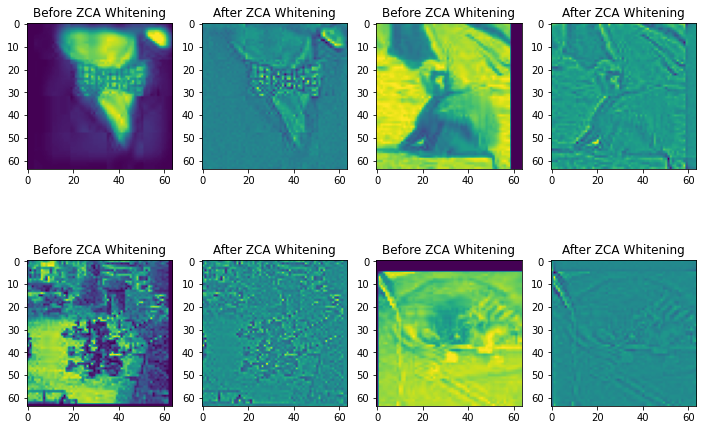

In [26]:
# Plotting comparison between unwhitened and whitened images
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(241)
ax1.imshow(X_train_saved[0])
ax1.set_title("Before ZCA Whitening")
ax2 = fig.add_subplot(242)
ax2.imshow(X_tr_norm_flat_white_rgb[13,0])
ax2.set_title("After ZCA Whitening")
ax3 = fig.add_subplot(243)
ax3.imshow(X_train_saved[1])
ax3.set_title("Before ZCA Whitening")
ax4 = fig.add_subplot(244)
ax4.imshow(X_tr_norm_flat_white_rgb[14,0])
ax4.set_title("After ZCA Whitening")
ax5 = fig.add_subplot(245)
ax5.imshow(X_train_saved[2])
ax5.set_title("Before ZCA Whitening")
ax6 = fig.add_subplot(246)
ax6.imshow(X_tr_norm_flat_white_rgb[15,0])
ax6.set_title("After ZCA Whitening")
ax7 = fig.add_subplot(247)
ax7.imshow(X_train_saved[3])
ax7.set_title("Before ZCA Whitening")
ax8 = fig.add_subplot(248)
ax8.imshow(X_tr_norm_flat_white_rgb[16,0])
ax8.set_title("After ZCA Whitening")